# Text to Image and Image to Image (In painting) generation with Bedrock

This notebook explains how to use Amazon Bedrock [Stable Diffusion XL](https://stability.ai/stablediffusion) model to generate images from text prompts, different negative prompts, style presets. Second part of the notebook takes the generated image and generates a new image with additions. 


This notebook provides prompt building with
* Image Preset - photographs, painting, sketch 
* Prompt text - Combine the descriptions of scene, onjetcs, environment, conditions etc 
* Additional Qualifers e.g. hyper realistic, realistic

## Install dependencies

In [ ]:
!pip install boto3 --upgrade

## Restart Kernel

In [ ]:
#Restart Kernel after the installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

## Setup

In [1]:
import io, base64
from matplotlib.pyplot import imshow
from PIL import Image
import json, os, sys

In [2]:
import boto3
import sagemaker
session = boto3.Session()
sagemaker_session = sagemaker.Session()
studio_region = sagemaker_session.boto_region_name 
bedrock = session.client("bedrock-runtime", region_name=studio_region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Generate Image from Text
In the below step, we generate an image with Prompt data Negative prompts, style presents

In [3]:
prompt_data = "Cool theme for a new SUV in Dubai, hypercar design, photorealistic render, 3d design, concept car, sapphire blue color"
neg_prompts = [
    "poorly rendered", 
    "poor background details"
    ]
style_preset = "photographic" 
seed = 20
steps = 50
cfg_scale = 10

modelId = "stability.stable-diffusion-xl" 
accept = "application/json"
contentType = "application/json"



pos = [{"text": prompt_data, "weight": 1}]
neg = [{"text": negp, "weight": -1} for negp in neg_prompts]

payload = {
    "text_prompts": pos + neg,
    "cfg_scale": cfg_scale,
    "seed": seed,
    "steps": steps,
    "style_preset": style_preset
}

body = json.dumps(payload)

response = bedrock.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

In [4]:
import io, base64
from matplotlib.pyplot import imshow
from PIL import Image
base_64_img_str = response_body.get("artifacts")[0].get("base64")
img1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))

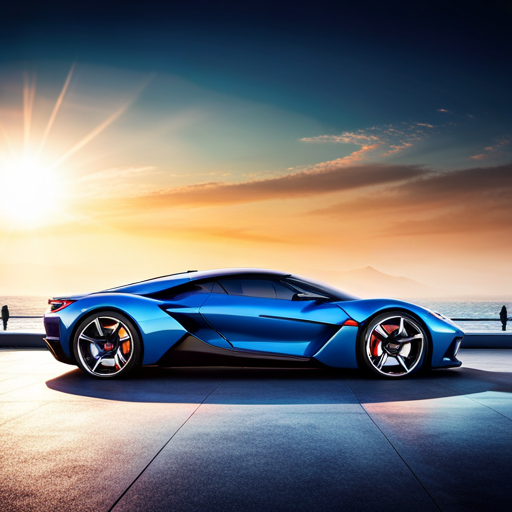

In [5]:
img1

## Image to Image Generation (In Painting)
We take the generated image from previous step and we add more details to this.

In [6]:
buffer = io.BytesIO()
img1.save(buffer, format="JPEG")
img1_bytes = buffer.getvalue()
img1_encoded = base64.b64encode(img1_bytes).decode()

In [7]:
prompt_data = "Add a date palm tree next to the car"

neg_prompts = [
    "poorly rendered", 
    "poor background details", 
    "convertible car"
    ]
style_preset = "photographic" 
seed = 20
steps = 50
cfg_scale = 10
start_schedule=0.6


modelId = "stability.stable-diffusion-xl" 
accept = "application/json"
contentType = "application/json"



pos = [{"text": prompt_data, "weight": 1}]
neg = [{"text": negp, "weight": -1} for negp in neg_prompts]

payload = {
    "text_prompts": pos + neg,
    "cfg_scale": cfg_scale,
    "seed": seed,
    "steps": steps,
    "style_preset": style_preset,
    "init_image": img1_encoded,
    "start_schedule": start_schedule,
    "sampler": "DDIM" 
}

body = json.dumps(payload)

response = bedrock.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

In [8]:
base_64_img2_str = response_body.get("artifacts")[0].get("base64")
img2 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img2_str, "utf-8"))))

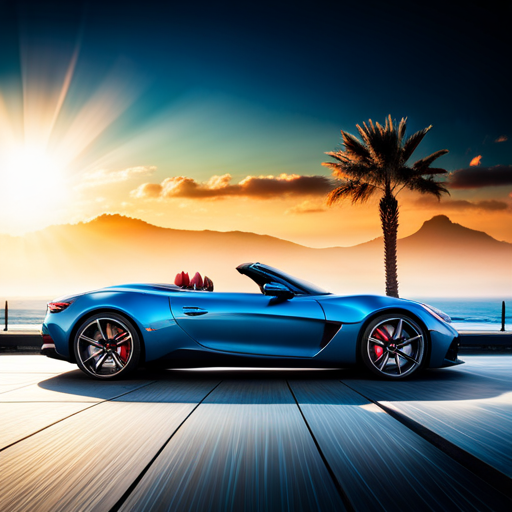

In [9]:
img2